# Exercise: Pyomo.DoE

In this notebook, you will use Pyomo.DoE to compute the A- and D-optimal experiments from the TCLab. In our [previous notebook](../notebooks/doe_optimize.ipynb), we used the sine test as a starting point. In this notebook, we will use the step test as the starting point.

Recall, we can computing the next best experiment assuming we already completed one prior experiment. Thus it is important to confirm our optimal experiment design does not change if we change the prior experiment of optimization initial point.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"
else:
    import os

    if "exercise_solutions" in os.getcwd():
        # Add the "notebooks" folder to the path
        # This is needed for running the solutions from a separate folder
        # You only need this if you run locally
        sys.path.append('../notebooks')

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data (step test)

We will load the step test experimental data, similar to our previous notebooks.

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.84,50.0,0.0
1,1.00,22.84,22.84,50.0,0.0
2,2.01,23.16,22.84,50.0,0.0
3,3.02,22.84,22.84,50.0,0.0
4,4.01,22.84,22.84,50.0,0.0


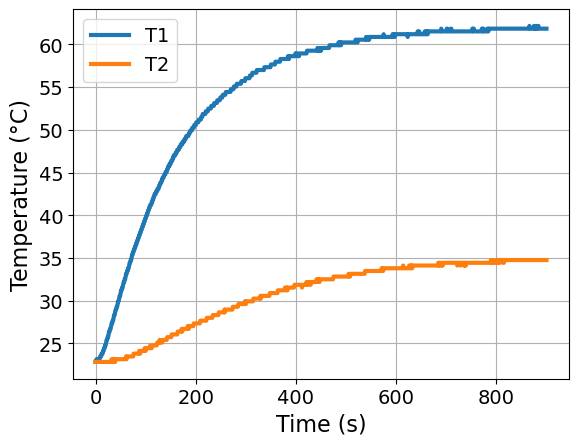

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')
ax.grid(True)

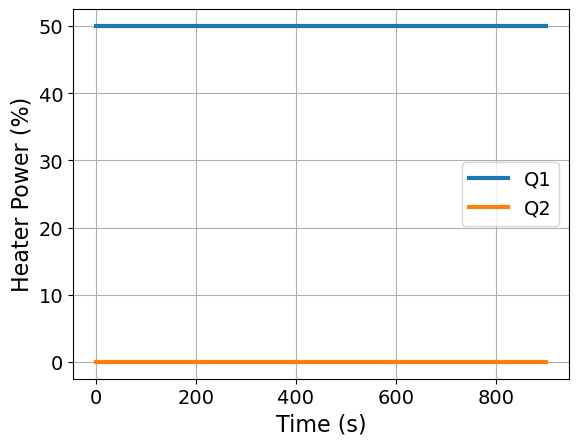

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')
ax.grid(True)

In [5]:
# Here, we will induce a step size of 10 seconds, as to not give too many 
# degrees of freedom for experimental design.
skip = 10

# Create the data object considering the new control points every 6 seconds
tc_data = TC_Lab_data(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values[::skip],
    T1=df['T1'].values[::skip],
    u1=df['Q1'].values[::skip],
    P1=200,
    TS1_data=None,
    T2=df['T2'].values[::skip],
    u2=df['Q2'].values[::skip],
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (step test)

To get started, compute and analyze the FIM of the step test experiment.

In [6]:
# Load Pyomo.DoE class
from pyomo.contrib.doe import DesignOfExperiments

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.0417051733576387,
    'Ub': 0.009440714239773074,
    'inv_CpH': 0.1659093525658045,
    'inv_CpS': 5.8357556063605465,
}

In [7]:
# Create experiment object for design of experiments
### BEGIN SOLUTION
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)
### END SOLUTION

# Create the design of experiments object using our experiment instance from above
### BEGIN SOLUTION
TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-3,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True, 
                                 tee=True,)
### END SOLUTION

# Calculate the FIM
### BEGIN SOLUTION
FIM = TC_Lab_DoE.compute_FIM(method='sequential')
### END SOLUTION

In [8]:
# Call our custom function to summarize the results
# and compute the eigendecomposition of the FIM

### BEGIN SOLUTION
results_summary(FIM)
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.478320483238926
D-optimality: -0.3720324752240514
E-optimality: -12.46232647470218
Modified E-optimality: 17.826307932446912

FIM:
 [[280021.49368497  -3263.8394116  -41417.03573773  -4504.32028723]
 [ -3263.8394116     504.43197491   2675.98382776    575.0360256 ]
 [-41417.03573773   2675.98382776  19642.3370869    3227.61385139]
 [ -4504.32028723    575.0360256    3227.61385139    661.27975811]]

eigenvalues:
 [2.86582756e+05 1.40455061e+04 2.01280068e+02 3.44884380e-13]

eigenvectors:
 [[ 9.87896911e-01 -1.54154336e-01  1.72085684e-02 -2.98455815e-09]
 [-1.27425470e-02 -1.59887295e-01 -7.00755497e-01 -6.95136974e-01]
 [-1.53613948e-01 -9.57155941e-01  2.44355356e-01 -2.33606507e-02]
 [-1.73227212e-02 -1.85809038e-01 -6.70026908e-01  7.18497646e-01]]


**Discussion:** How does this FIM compare to the sine test experiment we [previously analyzed](../notebooks/doe_exploratory_analysis.ipynb)?

## Optimize the next experiment (A-optimality)

Now we are ready to compute the A-optimal next best experiment. Why are we starting with A-optimality? It runs faster so it is better for debugging syntax.

In [9]:
# Create experiment object for design of experiments
### BEGIN SOLUTION
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)
### END SOLUTION

# Create the design of experiments object using our experiment instance from above
### BEGIN SOLUTION
TC_Lab_DoE_A = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-3,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True,
                                 objective_option="trace",  # Now we specify a type of objective, A-opt = "trace"
                                 prior_FIM=FIM,  # We use the prior information from the same existing experiment as in the D-optimal case!
                                 tee=True,)
### END SOLUTION

# Run DoE analysis
### BEGIN SOLUTION
TC_Lab_DoE_A.run_doe()
### END SOLUTION

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

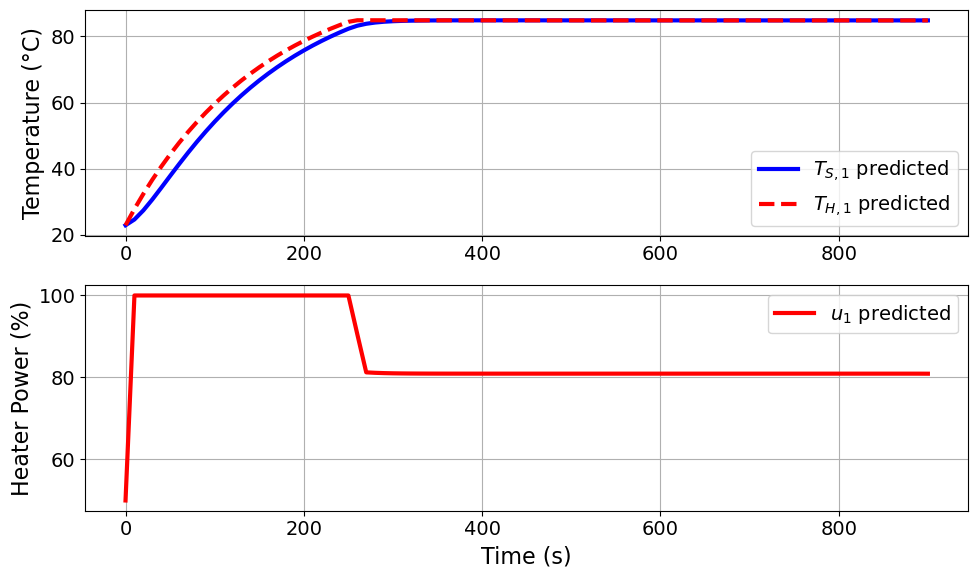

Model parameters:
Ua = 0.0417 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [10]:
# Extract and plot the results using our custom function
### BEGIN SOLUTION
aopt_pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE_A.model.scenario_blocks[0])
### END SOLUTION

In [11]:
# Compute the FIM at the optimal solution
### BEGIN SOLUTION
results_summary(TC_Lab_DoE_A.results['FIM'])
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 6.090133536295559
D-optimality: 2.241360976872912
E-optimality: -11.609405717044398
Modified E-optimality: 17.65585657421685

FIM:
 [[np.float64(1139518.5422627428), np.float64(-10472.244505541354), np.float64(-153717.0217915493), np.float64(-15129.58421210691)], [np.float64(-10472.244505541354), np.float64(2401.11914204594), np.float64(11878.960961562323), np.float64(2709.273907239065)], [np.float64(-153717.0217915493), np.float64(11878.960961562323), np.float64(85642.06394039834), np.float64(14277.233810316884)], [np.float64(-15129.58421210691), np.float64(2709.273907239065), np.float64(14277.233810316884), np.float64(3085.3850519264693)]]

eigenvalues:
 [1.16185717e+06 6.76652429e+04 1.12470124e+03 2.45807021e-12]

eigenvectors:
 [[ 9.89748997e-01 -1.41736376e-01  1.75420180e-02 -2.99665917e-09]
 [-1.04252983e-02 -1.59543643e-01 -7.00872118e-01 -6.95136974e-01]
 [-1.41676957e-01 -9.59182270e-01  2.43621206

**Discussion:** How do these compare to our [previous A-optimal results](../notebooks/doe_optimize.ipynb) considering the sine test as the prior experiment?

## Optimize the next experiment (D-optimality)

Finally, we are ready to solve the D-optimality problem. This may take 2 minutes to run.

In [12]:
# Create experiment object for design of experiments
### BEGIN SOLUTION
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)
### END SOLUTION

# Create the design of experiments object using our experiment instance from above
### BEGIN SOLUTION
TC_Lab_DoE_D = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-3,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True,
                                 objective_option="determinant",  # Now we specify a type of objective, D-opt = "determinant"
                                 prior_FIM=FIM,  # We use the prior information from the existing experiment!
                                 tee=True,)
### END SOLUTION

### BEGIN SOLUTION
TC_Lab_DoE_D.run_doe()
### END SOLUTION

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

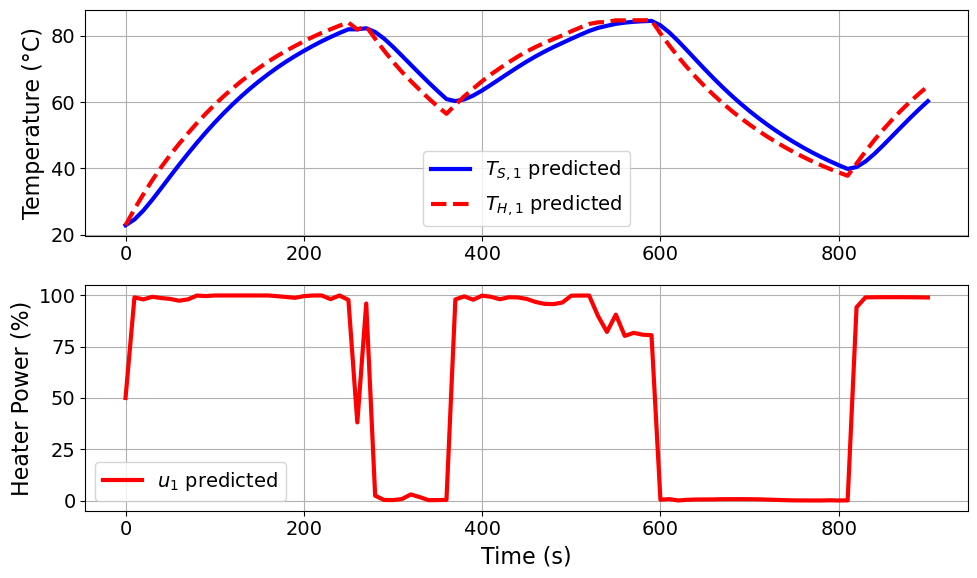

Model parameters:
Ua = 0.0417 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [13]:
# Extract and plot the results using our custom function
### BEGIN SOLUTION
dopt_pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE_D.model.scenario_blocks[0])
### END SOLUTION

In [14]:
# Compute the FIM at the optimal solution
### BEGIN SOLUTION
results_summary(TC_Lab_DoE_D.results['FIM'])
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.964057332167607
D-optimality: 4.146619465500874
E-optimality: -10.299299107984297
Modified E-optimality: 16.197009623744886

FIM:
 [[np.float64(812327.3045909577), np.float64(444.48997994088194), np.float64(-74458.8950669572), np.float64(-1990.8546372713727)], [np.float64(444.48997994088194), np.float64(4643.589676293455), np.float64(15635.929763733888), np.float64(5000.985557246354)], [np.float64(-74458.8950669572), np.float64(15635.929763733888), np.float64(98166.19140236262), np.float64(18319.25104827954)], [np.float64(-1990.8546372713727), np.float64(5000.985557246354), np.float64(18319.25104827954), np.float64(5434.004672223671)]]

eigenvalues:
 [8.20027868e+05 9.70151638e+04 3.52805897e+03 5.01996734e-11]

eigenvectors:
 [[ 9.94694459e-01  1.00295287e-01 -2.28864374e-02 -3.11136251e-09]
 [-1.45731301e-03  1.73636719e-01  6.97590682e-01 -6.95136970e-01]
 [-1.02753297e-01  9.59228310e-01 -2.62253865e-01

**Discussion:** How do these results compare to [our previous analysis](../notebooks/doe_exercise.ipynb)?